주가 예측 모형 구축

# 1. Setting Enviroment

## 1.1. Import library

In [1]:
# library import
import os
import sys
import time
import numpy as np
import scipy as sp
import pandas as pd
import re
from datetime import datetime, timedelta
from IPython.display import clear_output
import matplotlib.pyplot as plt

# crawling
import urllib
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import json
import urllib3
import http.client

# Oracle DB 연동
import cx_Oracle

# autocomplete 작동 안될때
%config Completer.use_jedi = False

In [2]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

## 1.2. Connect Oracle

In [4]:
# 한글 지원
os.putenv('NLS_LANG', '.UTF8')

username = 'system'
password = 'kv5900'
host = 'localhost/orcl'

# DB connect
conn = cx_Oracle.connect(username, password, host)

In [5]:
# test sql code
pd.read_sql('select * from DUAL', conn)

,DUMMY
0,X


## 1.3. Setting working directory

In [6]:
os.chdir('E:\\github\\python\\stock')

In [7]:
os.getcwd()

'E:\\github\\python\\stock'

## 1.4. Setting Variables

#### 가장 최근 영업일 crawling

In [137]:
url = 'https://finance.naver.com/sise/sise_index.nhn?code=KOSPI'

html = urlopen(url)
source = BeautifulSoup(html.read(), "lxml")
text = source.find_all('span', id='time')[0].text

basc_dt = re.sub('\\.', '', re.findall(('[0-9]+.[0-9]+.[0-9]+'), text)[0])
print(basc_dt)

20220222


In [138]:
stt_dt = '20000101'

# 2. Import Data

#### ETF 정보 호출

In [139]:
etf_list = {
              'STC_ETF_VT'      : 'VT'            # Vanguard Total World Stock Index Fund ETF Shares
            , 'STC_ETF_IAU'     : 'IAU'           # iShares Gold Trust 
            , 'STC_ETF_SHY'     : 'SHY'           # iShares 1-3 Year Treasury Bond ETF 
            , 'STC_ETF_IEF'     : 'IEF'           # iShares 7-10 Year Treasury Bond ETF
            , 'STC_ETF_TLT'     : 'TLT'           # iShares 20+ Year Treasury Bond ETF
            , 'STC_ETF_DBC'     : 'DBC'           # Invesco DB Commodity Index Tracking Fund
            , 'STC_ETF_LTPZ'    : 'LTPZ'          # PIMCO 15+ Year U.S. TIPS Index Exchange-Traded Fund
            
           }

In [140]:
# 모든 데이터 호출
for db_df, out_df in etf_list.items():
    q = "select * from "+ db_df + " where BASC_DT between " + stt_dt + " and " + basc_dt
    exec("{} = pd.read_sql(q, conn)".format(out_df))
    
    # 컬럼명 변경 (종가,저가,고가,시가 앞에 지표명 추가)
    exec("{}.rename(columns = dict(zip({}.columns[2:], '{}'+'_'+{}.columns[2:])), inplace=True)".format(out_df, out_df, out_df, out_df))

In [141]:
# etf 조인
for i, val in enumerate(etf_list.items()):
    
    db_df = val[0] # input table name (in sql)
    out_df = val[1] # call table name (in python)
    
    # loop를 위해.. df로 테이블명 통일
    exec("df = {}".format(out_df))
    
    df = df.drop('IDX_CD', inplace=False, axis=1) # IDX_CD 컬럼 제거
    if (i == 0):
        etf_df = df
    else:
        etf_df = etf_df.merge(df, how='outer', on='BASC_DT')
        
# order by BASC_DT        
etf_df = etf_df.sort_values('BASC_DT').reset_index(drop=True)

# 모든 컬럼값이 0 or na인 경우 제외
etf_df = etf_df.loc[:,etf_df.columns[~(etf_df.apply(lambda x: pd.Series([x.min(), x.max()])).sum() == 0)]]

# 0인값을 모두 null 처리함
etf_df = etf_df.replace(0, np.nan)

# index를 통한 join
#     exec("{} = {}.drop('IDX_CD', inplace=False, axis=1).set_index('BASC_DT')".format(out_df, out_df))
#     exec("idx = pd.concat([idx, {}], ignore_index=False, axis=1)".format(out_df))

In [142]:
etf_df

,BASC_DT,VT_OPN_PRC,VT_HGH_PRC,VT_LOW_PRC,VT_CLS_PRC,VT_VLM,VT_ADJ_PRC,IAU_OPN_PRC,IAU_HGH_PRC,IAU_LOW_PRC,IAU_CLS_PRC,IAU_VLM,IAU_ADJ_PRC,SHY_OPN_PRC,SHY_HGH_PRC,SHY_LOW_PRC,SHY_CLS_PRC,SHY_VLM,SHY_ADJ_PRC,IEF_OPN_PRC,IEF_HGH_PRC,IEF_LOW_PRC,IEF_CLS_PRC,IEF_VLM,IEF_ADJ_PRC,TLT_OPN_PRC,TLT_HGH_PRC,TLT_LOW_PRC,TLT_CLS_PRC,TLT_VLM,TLT_ADJ_PRC,DBC_OPN_PRC,DBC_HGH_PRC,DBC_LOW_PRC,DBC_CLS_PRC,DBC_VLM,DBC_ADJ_PRC,LTPZ_OPN_PRC,LTPZ_HGH_PRC,LTPZ_LOW_PRC,LTPZ_CLS_PRC,LTPZ_VLM,LTPZ_ADJ_PRC
0,20020730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.120003,81.129997,81.000000,81.010002,95300.0,58.722935,81.940002,82.120003,81.699997,81.769997,41300.0,46.482220,81.750000,81.900002,81.519997,81.519997,6100.0,42.148338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20020731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.169998,81.309998,81.150002,81.260002,38800.0,58.904175,82.050003,82.580002,82.050003,82.519997,32600.0,46.908524,81.949997,82.800003,81.900002,82.529999,29400.0,42.670551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20020801,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.330002,81.449997,81.330002,81.419998,86800.0,59.020103,82.540001,82.900002,82.519997,82.860001,71400.0,47.101822,82.540001,83.019997,82.540001,83.000000,25000.0,42.913578,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20020802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.459999,81.639999,81.400002,81.580002,83400.0,59.136074,83.019997,83.699997,82.900002,83.500000,120300.0,47.465618,83.160004,84.099998,82.879997,83.849998,52800.0,43.353054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20020805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.629997,81.730003,81.570000,81.709999,93100.0,59.230328,83.680000,83.919998,83.529999,83.919998,159300.0,47.704384,84.040001,84.440002,83.849998,84.220001,61100.0,43.544392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4921,20220214,101.139999,101.400002,100.129997,100.900002,4316400.0,100.900002,35.389999,35.639999,35.369999,35.580002,16345300.0,35.580002,84.279999,84.330002,84.220001,84.269997,4375400.0,84.269997,110.540001,110.830002,110.209999,110.370003,11090000.0,110.370003,137.130005,137.740005,135.970001,136.529999,23157400.0,136.529999,23.000000,23.360001,22.959999,23.250000,5164900.0,23.250000,80.949997,81.400002,80.440002,80.669998,97300.0,80.669998
4922,20220215,102.000000,102.769997,101.989998,102.669998,3022600.0,102.669998,35.259998,35.299999,35.110001,35.230000,13789500.0,35.230000,84.269997,84.320000,84.250000,84.300003,2127700.0,84.300003,110.050003,110.239998,109.959999,110.040001,8490500.0,110.040001,135.600006,135.839996,134.940002,134.979996,18200700.0,134.979996,22.910000,22.910000,22.700001,22.870001,4105100.0,22.870001,80.180000,80.330002,79.800003,79.809998,110400.0,79.809998
4923,20220216,102.279999,103.209999,102.029999,102.980003,9601400.0,102.980003,35.320000,35.610001,35.320000,35.610001,14515300.0,35.610001,84.330002,84.419998,84.309998,84.410004,3335200.0,84.410004,110.320000,110.339996,109.940002,110.269997,9007700.0,110.269997,135.949997,136.070007,134.509995,135.779999,16473700.0,135.779999,23.059999,23.230000,22.889999,22.900000,3950600.0,22.900000,80.339996,80.500000,79.879997,80.459999,67500.0,80.459999
4924,20220217,102.230003,102.309998,100.870003,100.989998,5645400.0,100.989998,35.980000,36.150002,35.919998,36.099998,18813600.0,36.099998,84.410004,84.459999,84.400002,84.459999,4442900.0,84.459999,110.529999,110.900002,110.519997,110.860001,8749500.0,110.860001,136.449997,137.570007,135.899994,136.789993,24508200.0,136.789993,22.959999,23.120001,22.910000,23.090000,3057600.0,23.090000,80.870003,81.400002,79.669998,80.330002,128200.0,80.330002


In [143]:
etf_opn = etf_df.loc[:,(etf_df.columns.str.contains('OPN_PRC'))|(etf_df.columns.isin(['BASC_DT']))]

etf_opn.columns = etf_opn.columns.str.replace('_OPN_PRC','')

In [144]:
etf_cls = etf_df.loc[:,(etf_df.columns.str.contains('_CLS_PRC'))|(etf_df.columns.isin(['BASC_DT']))]

etf_cls.columns = etf_cls.columns.str.replace('_CLS_PRC','')

In [145]:
etf_cls.tail(12)

,BASC_DT,VT,IAU,SHY,IEF,TLT,DBC,LTPZ
4914,20220203,101.919998,34.360001,84.870003,112.059998,141.089996,22.650000,82.830002
4915,20220204,102.370003,34.389999,84.699997,111.199997,139.009995,22.830000,81.779999
4916,20220207,102.250000,34.660000,84.720001,111.230003,139.100006,22.879999,81.860001
4917,20220208,103.029999,34.730000,84.629997,110.870003,138.169998,22.680000,81.739998
4918,20220209,104.709999,34.869999,84.620003,111.019997,138.429993,22.910000,82.080002
4919,20220210,103.199997,34.730000,84.190002,110.000000,136.229996,22.790001,80.470001
4920,20220211,101.410004,35.410000,84.449997,111.139999,138.250000,23.129999,81.510002
4921,20220214,100.900002,35.580002,84.269997,110.370003,136.529999,23.250000,80.669998
4922,20220215,102.669998,35.230000,84.300003,110.040001,134.979996,22.870001,79.809998
4923,20220216,102.980003,35.610001,84.410004,110.269997,135.779999,22.900000,80.459999


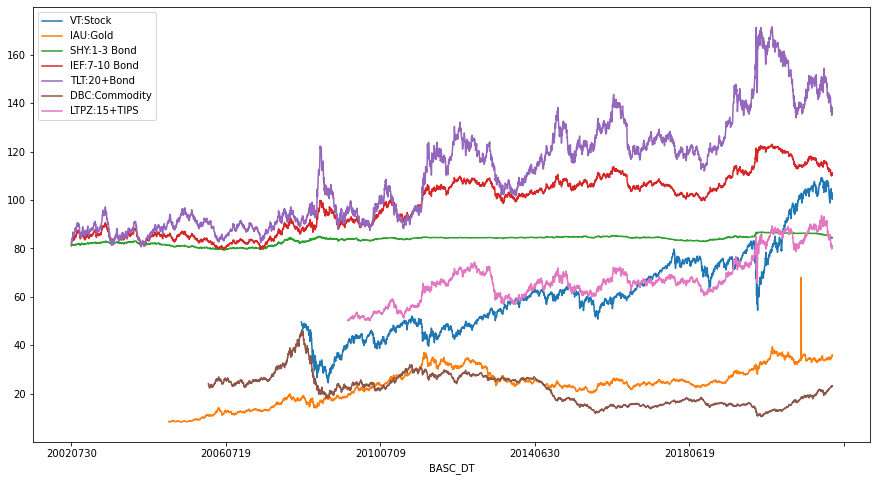

In [146]:
etf_cls.set_index('BASC_DT').plot(figsize=(15,8))
plt.legend(['VT:Stock','IAU:Gold','SHY:1-3 Bond','IEF:7-10 Bond','TLT:20+Bond','DBC:Commodity','LTPZ:15+TIPS'], loc='upper left')

# 3. Portfolio 구성

#### 자산별 비중 & 현재 보유수량

In [147]:
# 자산별 비중, 현재 보유수량
wgt = {
      'VT'   : [0.40, 28]  # Vanguard Total World Stock Index Fund ETF Shares
    , 'IAU'  : [0.05, 13]  # iShares Gold Trust 
    , 'SHY'  : [0.20, 19]  # iShares 1-3 Year Treasury Bond ETF 
    , 'IEF'  : [0.05,  4]  # iShares 7-10 Year Treasury Bond ETF
    , 'TLT'  : [0.05,  3]  # iShares 20+ Year Treasury Bond ETF
    , 'DBC'  : [0.05, 21]  # Invesco DB Commodity Index Tracking Fund
    , 'LTPZ' : [0.20, 19]  # PIMCO 15+ Year U.S. TIPS Index Exchange-Traded Fund
}

In [148]:
# 매수한 날짜 (시작가)
buy_dt = ['20211215']

In [149]:
# 최종일 (종가)
lst_dt = [etf_df.iloc[-1,0]]

In [175]:
# 추가 매수 예정 달러
add_ds = 8769.24

In [161]:
# 해당 일 etf 가격 추출
df = pd.concat([
    pd.DataFrame(wgt, index=['weight','shares']).T,
    etf_opn.loc[etf_opn['BASC_DT'].isin(buy_dt)].set_index('BASC_DT').T,
    etf_cls.loc[etf_cls['BASC_DT'].isin(lst_dt)].set_index('BASC_DT').T
], axis=1)

In [167]:
# 현재 보유 달러
df['hold_ds'] = df['shares']*df[lst_dt[0]]

In [172]:
# 현재 보유 종목별 비율
df['hold_rto'] = df['hold_ds']/sum(df['hold_ds'])

In [179]:
# 추가 매수 시 목표 달러
df['goal_ds'] = df['weight']* (sum(df['hold_ds']) + add_ds)

In [184]:
# 추가로 매수해야할 달러액
df['buy_ds'] = df['goal_ds'] - df['hold_ds']

In [190]:
# 추가로 매수해야할 수량
df['buy_shares'] = np.floor(df['buy_ds'] / df[lst_dt[0]])

In [193]:
df['buy_ds_f'] = df['buy_shares'] * df[lst_dt[0]]

In [196]:
df

,weight,shares,20211215,20220218,hold_ds,hold_rto,goal_ds,buy_ds,buy_shares,buy_ds_f
VT,0.40,28.0,105.389999,100.279999,2807.839972,0.361399,6615.443976,3807.604004,37.0,3710.359963
IAU,0.05,13.0,33.639999,36.060001,468.780013,0.060337,826.930497,358.150484,9.0,324.540009
SHY,0.20,19.0,85.540001,84.470001,1604.930019,0.206571,3307.721988,1702.791969,20.0,1689.400020
IEF,0.05,4.0,115.410004,111.220001,444.880004,0.057261,826.930497,382.050493,3.0,333.660003
TLT,0.05,3.0,149.610001,138.229996,414.689988,0.053375,826.930497,412.240509,2.0,276.459992
DBC,0.05,21.0,20.000000,23.180000,486.780000,0.062654,826.930497,340.150497,14.0,324.520000
LTPZ,0.20,19.0,89.169998,81.129997,1541.469943,0.198403,3307.721988,1766.252045,21.0,1703.729937


In [236]:
tmp = pd.concat([
    pd.DataFrame(wgt, index=['weight','shares']).T,
    etf_opn.loc[etf_opn['BASC_DT'].isin(['20180216'])].set_index('BASC_DT').T,
    etf_cls.loc[etf_cls['BASC_DT'].isin(lst_dt)].set_index('BASC_DT').T
], axis=1)

In [237]:
tmp

,weight,shares,20180216,20220218
VT,0.40,28.0,75.580002,100.279999
IAU,0.05,13.0,25.959999,36.060001
SHY,0.20,19.0,83.370003,84.470001
IEF,0.05,4.0,102.089996,111.220001
TLT,0.05,3.0,119.040001,138.229996
DBC,0.05,21.0,16.510000,23.180000
LTPZ,0.20,19.0,65.559998,81.129997


In [238]:
(sum(tmp['weight']*tmp[lst_dt[0]]) - sum(tmp['weight']*tmp['20180216']))/ sum(tmp['weight']*tmp[lst_dt[0]])

0.1744570774420033

In [186]:
# 이상치 처리 일반화 (Q3 + 15*IQR 보다 큰 값만 처리함 - 지나치게 이상한 경우)
cols = idx_df.columns.isin(['BASC_DT'])
idx_df.loc[:,~cols] = idx_df.loc[:,~cols].apply(lambda x: x[(x< (x.quantile(q=.75) + 15*(x.quantile(q=.75)-x.quantile(q=.25))))])

# 이상치 제거
# idx_df.loc[idx_df['BASC_DT']=='20030912','SSE_VLM'] = np.nan  # 말도안되게 큰 값이 들어가있음.. (10065200.0)
# idx_df.loc[idx_df['BASC_DT']=='20080317','USD_KRW_HGH_PRC'] = np.nan  # 말도안되게 큰 값이 들어가있음.. (21353.0)

In [187]:
# 값이 이상한 변수 제거 (금,은의 거래량 변수의 편차가 너무 심하게 큼)
idx_df = idx_df.drop(['GOLD_VLM','SILVER_VLM'], axis=1)
# 중복변수 제거
idx_df = idx_df.drop(['SP_CLS_PRC','DOW_CLS_PRC','NQ_CLS_PRC','RS2000_CLS_PRC','NI225_CLS_PRC','SSE_CLS_PRC','HSI_CLS_PRC',
                      'FTSE_CLS_PRC','FCHI_CLS_PRC','GDAXI_CLS_PRC','CLOIL_CLS_PRC','GOLD_CLS_PRC','SILVER_CLS_PRC',
                      'USD_KRW_CLS_PRC','USD_JPY_CLS_PRC','USD_EUR_CLS_PRC','USD_GBP_CLS_PRC'], axis=1)

In [188]:
# 결측치 처리 (linear로 처리함.. 최대 5개)
idx_df = idx_df.interpolate(method='values', limit_area='inside')

In [189]:
idx_df.shape

(5616, 90)

In [194]:
# 결측비율이 높은 컬럼 제거 - 5% 미만인 경우만 사용
sltcols = (idx_df.isna().sum(axis=0)/idx_df.shape[0])<0.05
sltcols = sltcols[sltcols].index
idx_df = idx_df[sltcols]

In [195]:
idx_df.shape

(5616, 74)

In [196]:
# 결측비율이 낮은 컬럼 처리 - 삭제 (처음과 끝부분만 남아있음 그냥 제거해줌)
narows = idx_df.isna().sum(axis=0)
print(narows[narows>0])
idx_df = idx_df.loc[idx_df.isna().any(axis=1)==False,:]

RS2000_VLM          1
NI225_OPN_PRC       1
NI225_HGH_PRC       1
NI225_LOW_PRC       1
NI225_ADJ_PRC       1
SSE_OPN_PRC         1
SSE_HGH_PRC         1
SSE_LOW_PRC         1
SSE_ADJ_PRC         1
FTSE_OPN_PRC        1
FTSE_HGH_PRC        1
FTSE_LOW_PRC        1
FTSE_VLM            2
FTSE_ADJ_PRC        1
GDAXI_VLM           1
CLOIL_OPN_PRC     167
CLOIL_HGH_PRC     167
CLOIL_LOW_PRC     167
CLOIL_VLM         167
CLOIL_ADJ_PRC     167
GOLD_OPN_PRC      172
GOLD_HGH_PRC      172
GOLD_LOW_PRC      172
GOLD_ADJ_PRC      172
SILVER_OPN_PRC    172
SILVER_HGH_PRC    172
SILVER_LOW_PRC    172
SILVER_ADJ_PRC    172
KOSPI_OPN_PRC       1
KOSPI_HGH_PRC       1
KOSPI_LOW_PRC       1
KOSPI_CLS_PRC       1
KOSPI_VLM           1
KOSDAQ_OPN_PRC      1
KOSDAQ_HGH_PRC      1
KOSDAQ_LOW_PRC      1
KOSDAQ_CLS_PRC      1
KOSDAQ_VLM          1
dtype: int64


### 테스트 데이터 생성

#### 종목별 주가 & 지표 Join

In [270]:
df = price_slt.merge(idx_df, how='inner', on='BASC_DT')

In [271]:
tt = df.loc[df['TKR_CD']=='007540'].reset_index(drop=True)

#### Target 변수 생성 

In [273]:
# 기간 내 최대 주가 생성을 위해 기간 지정 (10영업일로 지정)
tt.insert(2, 'TO_DT', tt['BASC_DT'].shift(-10))

In [274]:
# 최대 주가를 추출하기 위한 function
def create_target(row):
    tmp = tt[tt['BASC_DT'].between(row.BASC_DT, row.TO_DT)]
    return pd.Series([tmp['CLS_PRC'].max()], index=['MAX_PRC'])

In [275]:
# 최대 주가 추가
tt.insert(3, 'MAX_PRC', tt.apply(create_target, axis=1))

In [277]:
# 10영업일 이내 최대 수익률 변수 생성 (target)
tt.insert(3, 'TARGET', (tt['MAX_PRC']-tt['CLS_PRC'])/tt['CLS_PRC'])

In [287]:
tt['TARGET'] = tt['TARGET'].apply(lambda x: 1 if x>=0.1 else 0)

In [289]:
tt

,TKR_CD,BASC_DT,TO_DT,TARGET,MAX_PRC,OPN_PRC,HGH_PRC,LOW_PRC,CLS_PRC,VLM,SP_OPN_PRC,SP_HGH_PRC,SP_LOW_PRC,SP_VLM,SP_ADJ_PRC,DOW_OPN_PRC,DOW_HGH_PRC,DOW_LOW_PRC,DOW_VLM,DOW_ADJ_PRC,NQ_OPN_PRC,NQ_HGH_PRC,NQ_LOW_PRC,NQ_VLM,NQ_ADJ_PRC,RS2000_OPN_PRC,RS2000_HGH_PRC,RS2000_LOW_PRC,RS2000_VLM,RS2000_ADJ_PRC,NI225_OPN_PRC,NI225_HGH_PRC,NI225_LOW_PRC,NI225_ADJ_PRC,SSE_OPN_PRC,SSE_HGH_PRC,SSE_LOW_PRC,SSE_ADJ_PRC,HSI_OPN_PRC,HSI_HGH_PRC,HSI_LOW_PRC,HSI_ADJ_PRC,FTSE_OPN_PRC,FTSE_HGH_PRC,FTSE_LOW_PRC,FTSE_VLM,FTSE_ADJ_PRC,FCHI_OPN_PRC,FCHI_HGH_PRC,FCHI_LOW_PRC,FCHI_ADJ_PRC,GDAXI_OPN_PRC,GDAXI_HGH_PRC,GDAXI_LOW_PRC,GDAXI_VLM,GDAXI_ADJ_PRC,CLOIL_OPN_PRC,CLOIL_HGH_PRC,CLOIL_LOW_PRC,CLOIL_VLM,CLOIL_ADJ_PRC,GOLD_OPN_PRC,GOLD_HGH_PRC,GOLD_LOW_PRC,GOLD_ADJ_PRC,SILVER_OPN_PRC,SILVER_HGH_PRC,SILVER_LOW_PRC,SILVER_ADJ_PRC,USD_JPY_OPN_PRC,USD_JPY_HGH_PRC,USD_JPY_LOW_PRC,USD_JPY_ADJ_PRC,KOSPI_OPN_PRC,KOSPI_HGH_PRC,KOSPI_LOW_PRC,KOSPI_CLS_PRC,KOSPI_VLM,KOSDAQ_OPN_PRC,KOSDAQ_HGH_PRC,KOSDAQ_LOW_PRC,KOSDAQ_CLS_PRC,KOSDAQ_VLM
0,007540,20000830,20000918,0,4465.0,4531.0,4591.0,4350.0,4350,19100.0,1509.839966,1510.489990,1500.089966,8.184000e+08,1502.589966,11209.009766,11210.290039,11096.349609,146490000.0,11103.009766,4076.500000,4115.990234,4065.820068,1.537020e+09,4103.810059,529.630005,532.380005,529.109985,8.184000e+08,532.330017,17131.359375,17131.359375,16895.359375,16901.669922,2107.019043,2108.096924,2075.159912,2076.143066,17211.349609,17302.630859,16929.640625,17095.880859,6586.299805,6624.899902,6586.100098,9.329810e+08,6615.100098,6627.279785,6698.040039,6588.379883,6634.620117,7292.459961,7292.459961,7176.240234,31863300.0,7185.560059,32.750000,33.400002,32.099998,79214.0,33.400002,273.899994,273.899994,273.899994,273.899994,4.950000,4.950000,4.895000,4.930000,106.120003,106.709999,105.830002,106.610001,726.63,727.39,718.93,718.93,217557.0,1133.30,1134.00,1113.40,1119.50,212090.0
1,007540,20000831,20000919,0,4465.0,4319.0,4525.0,4319.0,4465,9130.0,1502.589966,1525.209961,1502.589966,1.056600e+09,1517.680054,11105.230469,11310.549805,11104.860352,183320000.0,11215.099609,4127.189941,4208.729980,4127.189941,1.903150e+09,4206.350098,532.359985,539.140015,532.359985,1.056600e+09,537.890015,16918.029297,17056.539063,16769.490234,16861.259766,2062.834961,2064.760010,2019.447021,2021.198975,17070.630859,17263.009766,16957.230469,17097.509766,6615.100098,6675.700195,6585.200195,1.410547e+09,6672.700195,6636.240234,6668.629883,6562.430176,6625.419922,7191.000000,7251.310059,7168.520020,34500100.0,7216.450195,33.250000,33.700001,32.970001,56895.0,33.099998,274.799988,278.299988,274.799988,278.299988,4.920000,5.045000,4.920000,5.003000,106.599998,106.820000,106.230003,106.669998,713.41,713.41,682.68,688.62,263369.0,1121.00,1122.80,1057.10,1085.90,199184.0
2,007540,20000901,20000920,0,4441.0,4507.0,4525.0,4356.0,4441,12950.0,1517.680054,1530.089966,1515.530029,7.677000e+08,1520.770020,11219.540039,11313.599609,11219.540039,125140000.0,11238.780273,4252.149902,4259.870117,4192.890137,1.472940e+09,4234.330078,537.890015,541.909973,536.549988,7.677000e+08,541.909973,16915.039063,17018.519531,16700.359375,16739.779297,2009.151001,2026.350952,1997.717041,1999.859009,17210.330078,17391.009766,17210.330078,17333.609375,6672.700195,6838.600098,6672.700195,1.315938e+09,6795.000000,6648.640137,6843.859863,6648.640137,6813.660156,7221.410156,7397.120117,7221.410156,47210000.0,7344.669922,33.049999,33.450001,32.750000,45869.0,33.380001,277.000000,277.000000,277.000000,277.000000,5.035000,5.035000,4.985000,5.004000,106.660004,106.720001,105.529999,105.949997,690.93,698.28,685.32,692.19,202369.0,1086.00,1103.00,1073.70,1089.40,229237.0
3,007540,20000904,20000921,0,4362.0,4410.0,4470.0,4319.0,4362,8310.0,1519.225037,1525.429993,1509.869995,8.031000e+08,1513.924988,11220.649902,11307.634765,11202.154785,149820000.0,11249.695312,4229.044921,4233.189942,4168.035157,1.570530e+09,4188.755127,539.899994,542.349976,537.479981,8.031000e+08,540.464997,16764.330078,16883.310547,16

# 3. Create Variables

In [305]:
train = tt.loc[tt['BASC_DT']< '20200701'].drop(['TKR_CD','BASC_DT','TO_DT','MAX_PRC'], axis=1)
test  = tt.loc[tt['BASC_DT']>='20200701'].drop(['TKR_CD','BASC_DT','TO_DT','MAX_PRC'], axis=1)

In [308]:
X, y = train.drop(['TARGET'],axis=1).values, train['TARGET']
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=.2, random_state=1234)

In [309]:
test_X, test_y = test.drop(['TARGET'],axis=1).values, test['TARGET']

# 4. Build Models

#### Lasso 를 활용하여 변수 선택

In [316]:
lasso = Lasso(alpha=1, random_state=12)
lasso.fit(train_X,train_y)
train_score = lasso.score(train_X,train_y)
valid_score = lasso.score(valid_X,valid_y)
coeff_used = np.sum(lasso.coef_!=0)

print("training score:", train_score)
print("valid score: ", valid_score)
print("number of features used: ", coeff_used)

training score: 0.05638868739354186
valid score:  0.03889095482376037
number of features used:  25


C:\Users\user\anaconda3\envs\gpu\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253.38092204053768, tolerance: 0.05347833078101094
  positive)


In [318]:
list(zip(tt.drop(['TARGET','TKR_CD','BASC_DT'],axis=1).columns, lasso.coef_))

[('TO_DT', 1.1016113737377478e-05),
 ('MAX_PRC', 2.25488376273081e-05),
 ('OPN_PRC', -6.658972939835455e-05),
 ('HGH_PRC', 2.4547830350178875e-05),
 ('LOW_PRC', -3.122268875530378e-08),
 ('CLS_PRC', 0.0),
 ('VLM', 0.0),
 ('SP_OPN_PRC', 0.0),
 ('SP_HGH_PRC', 3.080016027822235e-11),
 ('SP_LOW_PRC', 1.9319233743364253e-05),
 ('SP_VLM', -0.0),
 ('SP_ADJ_PRC', 0.0),
 ('DOW_OPN_PRC', 0.0),
 ('DOW_HGH_PRC', -5.831345539267832e-10),
 ('DOW_LOW_PRC', 2.710745725873536e-06),
 ('DOW_VLM', 0.0),
 ('DOW_ADJ_PRC', 1.2223656430566626e-05),
 ('NQ_OPN_PRC', 0.0),
 ('NQ_HGH_PRC', 4.250531090811763e-11),
 ('NQ_LOW_PRC', 8.5953604277747e-06),
 ('NQ_VLM', 0.0),
 ('NQ_ADJ_PRC', 0.0),
 ('RS2000_OPN_PRC', 0.0),
 ('RS2000_HGH_PRC', -1.9687512707392624e-11),
 ('RS2000_LOW_PRC', 0.0),
 ('RS2000_VLM', 0.0),
 ('RS2000_ADJ_PRC', 3.0518776455572216e-05),
 ('NI225_OPN_PRC', 0.0),
 ('NI225_HGH_PRC', 2.4177765564387144e-06),
 ('NI225_LOW_PRC', -0.0),
 ('NI225_ADJ_PRC', -0.0),
 ('SSE_OPN_PRC', -4.134343430093108e-06),
 

In [319]:
lgb_train = lgb.Dataset(train_X, train_y)
lgb_valid = lgb.Dataset(valid_X, valid_y, reference=lgb_train)
lgb_test = lgb.Dataset(test_X, test_y)

In [320]:
param = {'learning_rate':0.1,
         'max_depth':10,
         'num_leaves':144,
         'min_data_in_leaf':40,
         'boosting':'gbdt',
         'feature_fraction':0.8,
         'bagging_fraction':0.8,
         'bagging_freq':5,
         'objective':'regression',
         'metric':'mse',
         'verbose':5,
         'seed':1234,
         
        }

In [321]:
lgb_model = lgb.train(params = param, 
                      train_set = lgb_train, 
                      valid_sets = lgb_valid, 
                      num_boost_round=100, 
                      early_stopping_rounds=50)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000292 seconds, init for row-wise cost 0.001269 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19890
[LightGBM] [Info] Number of data points in the train set: 3918, number of used features: 78
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] Start training from score 0.163093
[LightGBM] [Debug] Re-bagging, using 3157 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 38 and depth = 10
[1]	valid_0's l2: 0.129788
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 41 and depth = 10
[2]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 36 and depth = 10
[91]	valid_0's l2: 0.0728847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[92]	valid_0's l2: 0.0727624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 22 and depth = 10
[93]	valid_0's l2: 0.072708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and depth = 10
[94]	valid_0's l2: 0.0727065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 27 and depth = 10
[95]	valid_0's l2: 0.0726667
[LightGBM] [Debug] Re-bagging, using 3130 data to train
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] T

In [322]:
train_p = lgb_model.predict(train_X)
valid_p = lgb_model.predict(valid_X)
test_p = lgb_model.predict(test_X)

In [323]:
mse = mean_squared_error(test_y, test_p)
r2 = r2_score(test_y, test_p)

In [325]:
list(zip(test_y, test_p))

[(0, 0.1776890547674224),
 (0, 0.09768305518106768),
 (0, 0.1406474552550863),
 (0, 0.18256526325323302),
 (0, 0.1678993182479453),
 (0, 0.1769393731494664),
 (0, 0.15013464882801916),
 (1, 0.07799466002208809),
 (1, 0.18463534763344008),
 (1, 0.19621088276205884),
 (1, 0.20094417857035962),
 (1, 0.22482401132006666),
 (1, 0.17733403922412733),
 (1, 0.16908287815293702),
 (1, 0.2096481837353514),
 (1, 0.1770218948189395),
 (0, 0.124905208064806),
 (0, 0.09915431651187595),
 (0, 0.1357655626711999),
 (0, 0.18998137855298258),
 (0, 0.13989586607546312),
 (0, 0.17325521447453776),
 (0, 0.30125608706936585),
 (0, 0.3622140733489158),
 (0, 0.26927018127462676),
 (0, 0.2327946696876098),
 (0, 0.23095272823252042),
 (0, 0.1667281921527186),
 (0, 0.1659388640238084),
 (0, 0.2130120170975755),
 (0, 0.22546612159825932),
 (0, 0.16043281376315954),
 (0, 0.1459479692190654),
 (0, 0.12966970881528478),
 (0, 0.17545536966949177),
 (0, 0.24569776834684331),
 (0, 0.2701199062953305),
 (0, 0.2470080917

In [249]:
s = 'aaasdfbbcc'

In [250]:

def solution(s):
    # Write your code here
    once = []

    for l in set(s):
        if s.count(l)<=1:
            tmp = [l, s.count(l)]
            once.append(tmp)
    
    if len(once)==0:
        out = -1
    else:
        
        idx = []
        for i in dict(once).keys():
            idx.append([i, s.find(i)])
            
        out = s.find(min(dict(idx), key=dict(idx).get))+1
    
    return out

In [251]:
solution(s)

4

In [275]:
n = 24

In [276]:
x = list(str(n))

In [277]:
list(map(int, x))

[2, 4]

In [280]:

def solution(n):
    # Write your code here
    
    # factorial 계산 함수 작성
    def factorial(n):
        fact = 1
        for i in range(1, n+1):
            fact *= i
        return fact
    
        
    out = [list(map(int, x)) for x in list(str(n))]

    return out

In [296]:
n = 4

In [297]:
    
# 공격력 산출 함수 작성
def power(n):    

    # factorial 계산 함수 작성
    def factorial(n):
        fact = 1
        for i in range(1, n+1):
            fact *= i
        return fact


    out = [x for x in list(str(n))] # 각 자리수 list로 변환
    # factorial 실행 및 공격력 생성
    power = 0
    for i in out:
        power += factorial(int(i))
    return power

team = [n]
while True:

    n = power(n)

    if n in team:
        break
    team.append(n)

In [301]:
max(team)*len(team)

2908808

In [347]:
arr = [4,1,2,3,6,9]

In [348]:

    # 처음으로 증가하기 시작한 배열 index추출
    stt = 0
    for idx, val in enumerate(list(arr)):
        if idx == len(arr)-1:
            pass
            
        else:
            
            if arr[idx] > arr[idx+1]:
                pass
            else:
                stt = idx
                break
    

In [352]:
arr2 = arr[stt:]

In [366]:
for idx, val in enumerate(list(arr2)):
    print(idx, val)

0 1
1 2
2 3
3 6
4 9


In [378]:
end = len(arr)-1
for idx, val in enumerate(list(arr2)):
    print(idx, val)
    if idx == len(arr2)-1:
        pass
    else:
        if arr2[idx] >= arr2[idx+1]:
            end = idx
            pass
        else:
            break
        

0 1


In [379]:
end

0

In [361]:
end

5

In [342]:
for idx, val in enumerate(reversed(list(arr))):
    if idx == len(arr)-1:
        end = idx
    else:
        if arr[idx] > arr[idx+1]:
            pass
        else:
            end = len(arr) - idx - 1
            break

In [ ]:
#!/bin/python3

import math
import os
import random
import re
import sys



#
# Complete the 'solution' function below.
#
# The function is expected to return an INTEGER.
# The function accepts INTEGER_ARRAY arr as parameter.
#

def solution(arr):
    # Write your code here
    
    updown =[]
    for idx, val in enumerate(list(arr)):
        if idx == 0:
            if arr[idx] <= arr[idx+1]:
                updown.append([idx, val, 'upper'])
            else:
                updown.append([idx, val, 'down'])
        elif idx == len(arr)-1:
            if arr[idx-1] >= arr[idx]:
                updown.append([idx, val, 'lower'])
            else:
                updown.append([idx, val, 'up'])
        else:
            if arr[idx-1]<=arr[idx]<=arr[idx+1]:
                updown.append([idx, val, 'up'])
            elif arr[idx-1]>=arr[idx]>=arr[idx+1]:
                updown.append([idx, val, 'down'])
            elif arr[idx-1]>arr[idx] and arr[idx]<=arr[idx+1]:
                updown.append([idx, val, 'lower'])
            elif arr[idx-1]<=arr[idx] and arr[idx]>arr[idx+1]:
                updown.append([idx, val, 'upper'])
                    
              
    
    return updown

    
    
if __name__ == '__main__':

In [343]:

def solution(arr):
    # Write your code here
    
    # 처음으로 증가하기 시작한 배열 index추출
    stt = 0
    for idx, val in enumerate(list(arr)):
        if idx == len(arr)-1:
            pass
            
        else:
            
            if arr[idx] > arr[idx+1]:
                pass
            else:
                stt = idx
                break
    
    # 역순으로 감소가 발생하기 시작하는 index추출
    end = 0
    arr2 = arr[stt:]
    for idx, val in enumerate(reversed(list(arr2))):
        if idx == len(arr2)-1:
            end = len(arr)
            
        else:
            if arr2[idx] > arr2[idx+1]:
                pass
            else:
                end = len(arr2) - idx - 1
                break
    
    return stt, end

4

In [381]:
def avg_percentage(game_id, ft_number, team, result):
    """
    :param game_id: (list) The ID of the game. 
    :param ft_number: (list) The number of the free throw.
    :param team: (list) Which team took the free throw.
    :param result: (list) The result of the free throw, which is either missed or made.
    :returns: (float) The mean value of the percentages (0.0-100.0) of free throws that
               each team scored in each game.
    """
    
    df = pd.DataFrame({'game_id':game_id,
                       'ft_number':ft_number,
                       'team':team,
                       'result':result
                      })
    
    
    return df

#For example, with the parameters below, the function should return 58.33
df = avg_percentage(
    [1, 1, 1, 1, 2, 2],
    [1, 2, 3, 4, 1, 2],
    ['home','home','away','home','away','home'],
    ['made','missed','made','missed','missed','made']
)

In [382]:
df

,game_id,ft_number,team,result
0,1,1,home,made
1,1,2,home,missed
2,1,3,away,made
3,1,4,home,missed
4,2,1,away,missed
5,2,2,home,made


In [403]:
df['result'] = df['result'].apply(lambda x: 1 if x=='made' else 0)

In [405]:
df.groupby(['team','game_id']).agg({'ft_number':'count', 'result':'sum'})

ft_number  result
team game_id                   
away 1                1       1
     2                1       0
home 1                3       1
     2                1       1

In [399]:
dfg = df.groupby(['team','game_id']).count()

In [400]:
dfg

ft_number  result
team game_id                   
away 1                1       1
     2                1       1
home 1                3       3
     2                1       1

In [406]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics

def train_and_predict(train_input_features, train_outputs, prediction_features):
    """
    :param train_input_features: (numpy.array) A two-dimensional NumPy array where each element
                        is an array that contains two numerical features
    :param train_outputs: (numpy.array) A one-dimensional NumPy array where each element
                        is the value associated with the same row of train_input_features
    :param prediction_features: (numpy.array) A two-dimensional NumPy array where each element
                        is an array that contains two numerical features
    :returns: (list) The function should return an iterable (like list or numpy.ndarray) of predictions,
                        one for each item in prediction_features
    """   
    pass

#Example case
np.random.seed(1)
data = np.random.normal(size=(200, 2))
result = 2 * data[:, 0] ** 3 + 4 * data[:, 1]
X_train, X_test, y_train, y_test = train_test_split(data, result,
                                                    test_size=0.3, random_state=0)

y_pred = train_and_predict(X_train, y_train, X_test)
if y_pred is not None:
    print(metrics.mean_squared_error(y_test, y_pred))

In [ ]:
poly = PolynomialFeatures(degree=2)
X_ = poly.fit_transform(X)
predict_ = poly.fit_transform(predict)

clf = linear_model.LinearRegression()
clf.fit(X_, vector)
print clf.predict(predict_)

In [431]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [451]:
poly = PolynomialFeatures(degree=3)

X_train_poly = poly.fit_transform(X_train)

X_test_poly = poly.transform(X_test)

model = LinearRegression()
model.fit(X_train_poly, y_train)

y_pred = model.predict(X_test_poly)

In [460]:
import pandas as pd
import math

def num_names(names, required_pct):
    """
    :param names: (list) A list of first names.
    :param required_pct: (int) The required percentage of the sample data to be preprinted.
    :returns: (int) The minimum number of unique first names (or templates) that need to be prepared.
    """
    return None
        
names = ["James", "Sophia", "James", "Sophia", "James", "Sophia", "Emma", "Jack"]
print(num_names(names, 75))

None


In [502]:
df = pd.DataFrame(names)[0].value_counts().reset_index().rename(columns={'index':'name', 0:'count'})

In [506]:
df['cum_pct'] = df['count'].cumsum()/df['count'].sum()*100

In [535]:
required_pct = 75

In [536]:
row_num = df.query("cum_pct < {}".format(required_pct)).shape[0]+1

In [537]:
df.iloc[:row_num].shape[0]

2

In [488]:
df.sort_values('count', ascending=False)

,name,count
0,James,3
1,JamesSophia,6
2,JamesSophiaEmma,7
3,JamesSophiaEmmaJack,8


In [470]:
np.unique(names, return_counts=True)

,0,1,2,3
0,Emma,Jack,James,Sophia
1,1,1,3,3


In [469]:
counts

array([1, 1, 3, 3], dtype=int64)